In [1]:
import sys
sys.path.append("../../../sampler-comparison")
sys.path.append("../../../sampler-evaluation")
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
sys.path.append("../../../../blackjax")

from sampler_comparison.samplers.general import make_log_density_fn
import blackjax
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

import numpy as np
import jax
import jax.numpy as jnp
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from matplotlib import pyplot as plt

def las(num_adjusted_steps, num_chains, diagonal_preconditioning=True, target_acceptance_rate=0.8):

    def s(model, key):

        logdensity_fn = make_log_density_fn(model)

        unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_size_adaptation_state = blackjax.adaptation.las.las(
            logdensity_fn=logdensity_fn,
            key=key,
            ndims=model.ndims,
            num_adjusted_steps=num_adjusted_steps,
            num_chains=num_chains,
            diagonal_preconditioning=diagonal_preconditioning,
            target_acceptance_rate=target_acceptance_rate
        )
        return unadjusted_position, adjusted_position, infos, num_steps_unadjusted

        
    return s


2025-10-21 11:04:08.831847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761069848.848810 1976244 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761069848.853814 1976244 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# run las on banana
model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# model = stochastic_volatility_mams_paper
# num_steps1 = 1000
num_adjusted_steps = 2000
num_chains = 1000
diagonal_preconditioning = True
print("running las")
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning)
unadjusted_samples, adjusted_samples, infos, num_steps_unadjusted = sampler(model, key=jax.random.key(0))
# print(samples)
# print(samples.shape)



running las
thinning_rate 4
alg SamplingAlgorithm(init=<function as_top_level_api.<locals>.init_fn at 0x7f8ba051c900>, step=<function thin_algorithm.<locals>.step_fn at 0x7f8ba051c9a0>)
step_size 0.0
step_size 0.0
step_size 0.0
step_size 0.0010000000474974513
step_size 0.0010000000474974513
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.009999999776482582
step_size 0.00999999977648

In [3]:
num_steps_unadjusted

3405

In [4]:
# print(model.sample_transformations["square"].ground_truth_mean[1])
# print(unadjusted_samples[:,1].mean())

print((((model.sample_transformations["square"].ground_truth_mean - (unadjusted_samples**2).mean(axis=0)))**2 )/(model.sample_transformations["square"].ground_truth_standard_deviation**2))


((((model.sample_transformations["square"].ground_truth_mean - (adjusted_samples[0]**2).mean(axis=0)))**2 )/(model.sample_transformations["square"].ground_truth_standard_deviation**2))





[4.3756423e-05 7.6270202e-04]


Array([4.4088261e-05, 7.6227373e-04], dtype=float32)

In [5]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.max
    )[0]

adjusted_error_at_each_step = ((((adjusted_samples**2).mean(axis=1) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)


adjusted_error_at_each_step_single = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2))

unadjusted_error_at_each_step.shape

(851,)

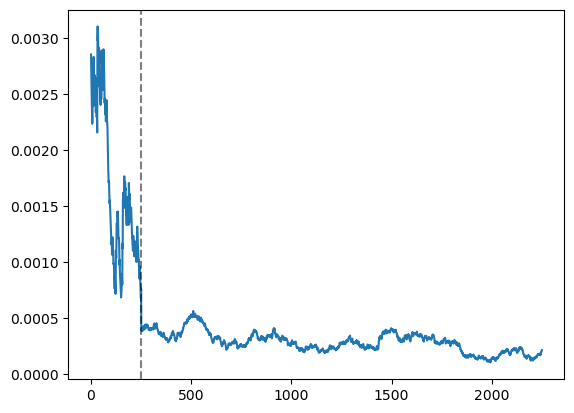

In [6]:
### COUNT GRADIENT CALLS!!!! TODO TODO
drop_first_n_steps = 600
plt.plot(np.concatenate([unadjusted_error_at_each_step[drop_first_n_steps:], adjusted_error_at_each_step[:]]))
# add a vertical line at the end of the unadjusted phase
plt.axvline(x=unadjusted_error_at_each_step.shape[0] - drop_first_n_steps, color='black', linestyle='--', alpha=0.5)
# plt.plot(unadjusted_error_at_each_step)
# save in sampler-comparison/sampler_comparison/experiments/results/figures
# plt.savefig(f'las_bias_{model.name}.png')
plt.show()
plt.close()
# plt.plot(adjusted_error_at_each_step)
# plt.show()
# plt.savefig(f'las_bias_adjusted_{model.name}.png')
# plt.close()

In [32]:
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# num_steps1 = 1000
num_adjusted_steps = 100
num_chains = 200
diagonal_preconditioning = True
print("running las")
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning)
unadjusted_samples_gaussian, adjusted_samples_gaussian, infos_gaussian, num_steps_unadjusted_gaussian = sampler(model, key=jax.random.key(0))

running las
num_alba_steps: 10000
thinning_rate: 50
new_num_alba_steps: 200
params before alba tuning (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True))
ess after alba (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True), Array([71.10184 , 60.654648], dtype=float32))
thinning_rate 152
alg SamplingAlgorithm(init=<function as_top_level_api.<locals>.init_fn at 0x7f0514320180>, step=<function thin_algorithm.<locals>.step_fn at 0x7f051448a340>)


(100, 199, 2)


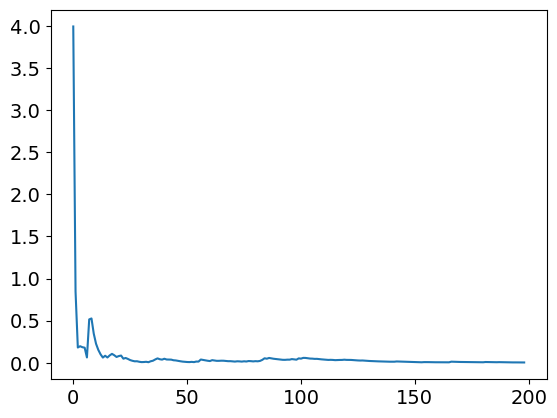

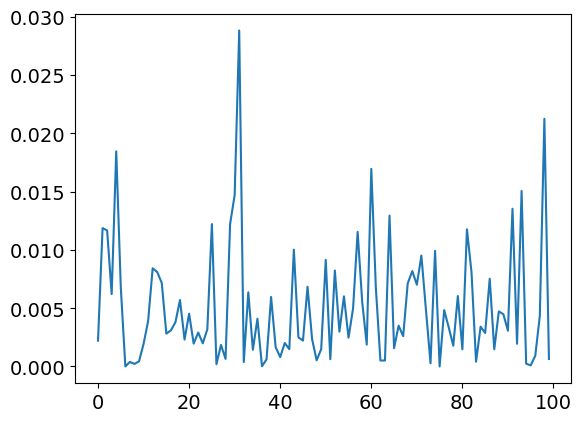

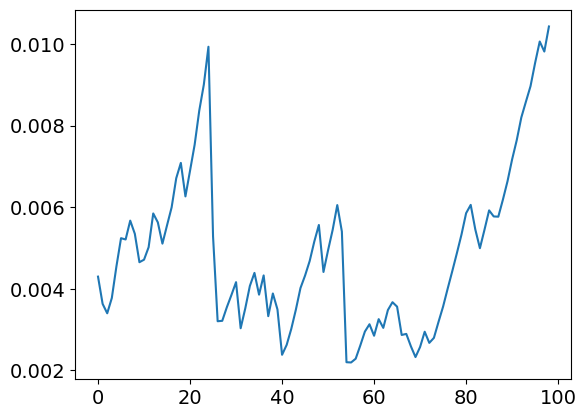

In [ ]:
def calculate_error(unadjusted_samples, adjusted_samples):

    print(adjusted_samples.shape)

    unadjusted_error_at_each_step = get_standardized_squared_error(
        unadjusted_samples[None, :, :], 
        f=model.sample_transformations["square"].fn,
        E_f=model.sample_transformations["square"].ground_truth_mean,
        Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
        contract_fn=jnp.max
        )[0]

    # bug: doesn't change when...
    adjusted_single = get_standardized_squared_error(
        adjusted_samples[5:, :, :], 
        f=model.sample_transformations["square"].fn,
        E_f=model.sample_transformations["square"].ground_truth_mean,
        Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
        contract_fn=jnp.max
        )[0]

    # note that we take mean across dims
    adjusted_error_at_each_step = ((((adjusted_samples**2).mean(axis=1) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)


    # adjusted_error_at_each_step_single = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2))

    return unadjusted_error_at_each_step, adjusted_error_at_each_step, adjusted_single

unadjusted_error_at_each_step_gaussian, adjusted_error_at_each_step_gaussian, adjusted_single_gaussian = calculate_error(unadjusted_samples_gaussian[:], adjusted_samples_gaussian)

plt.plot(unadjusted_error_at_each_step_gaussian)
plt.show()
plt.plot(adjusted_error_at_each_step_gaussian)
plt.show()
plt.plot(adjusted_single_gaussian[100:])
plt.show()



